<a href="https://colab.research.google.com/github/sungbinlim/mge51101-instruct/blob/master/coursework/Lecture_8_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic time series with RNN and GRU
## Iskakov Alisher

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

### Generating synthetic time series

Let's suppose simple regression problem.

$$
f(t) = \sin(0.01t) + 0.2 \epsilon,\quad \epsilon\sim\mathcal{N}(0,1), \quad t\in [0,1000]
$$

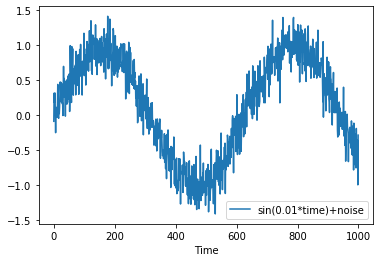

In [96]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

We generated 1000 data points of a sin-curve, adding a random normal noise with mean 0 and standard deviation 1.
This generated data will be used to make estimations and predictions.

### AutoRegressive (AR) Model

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step (credits to https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

Autoregressive models predict a next time step based on the previous observations. Since the sequence size can vary, we have to select a value for $\tau$ (timespan). It determines how many previous observations will be taken into account when predicting the next value in sequence.

Let's take $\tau = 4$ for `timespan` (or embedding dimension)

$$
y_{t} = x_{t},\quad \mathbf{z}_{t}(x_{t-1},\ldots, x_{t-\tau})
$$

So our model will accept 4 input values (previous observations) and output only 1 value (next observation).

Here we define a tensor for features and labels. Features will containt 996 samples consisting of 4 values, and there will be 996 labels.

Features:

$$
[[X_0,X_1,X_2,X_3], \\
[X_1,X_2,X_3,X_4], \\
... \\
[X_{995},X_{996},X_{997},X_{998}]] \\
$$

Labels:
$$
[X_4,X_5,...,X_{999}]
$$

In [97]:
# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
features = torch.zeros((T-tau, tau)) # AR Model needs tau inputs: shape is (996, 4)

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)]
labels = X[tau:] # shape is (996, )

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

### MLP

We can simply use a multi-layer perceptron to predict an output value from given input values.

In [98]:
# Parameter Initialization
def init_weight(map_):
    if type(map_) == nn.Linear:
        torch.nn.init.xavier_uniform_(map_.weight)

# Vanilla MLP architecture
def MLP():
    net = nn.Sequential()
    net.add_module("Linear_1", nn.Linear(tau, 10, bias=False))
    net.add_module("ReLU", nn.ReLU())
    net.add_module("Final", nn.Linear(10, 1, bias=False))
    net.apply(init_weight)

    return net

With autoregressive model using MLP we just minimize a mean-squared error of loss function.

In [108]:
# Least mean squares loss
criterion = nn.MSELoss()
# Adam optimizer
optimizer = torch.optim.Adam

In [103]:
# textbook code
def train_net(net, data, criterion, epochs, lr_rate):
    optim = optimizer(net.parameters(), lr=lr_rate)
    data_iter = DataLoader(data, batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        
        for x, y in data_iter:
            optim.zero_grad()
            output = net(x)
            loss = criterion(output, y.reshape(-1, 1))
            loss.backward()
            optim.step()
            running_loss += loss.item()
        
        print("epoch: {}, loss: {:.2f}".format(epoch, running_loss))
    
    test_loss = criterion(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
    print('test loss: %f' % test_loss.mean().detach().numpy())

    return net
    
net = MLP()
net = train_net(net, train_data, criterion, 10, 0.01)

epoch: 1, loss: 5.56
epoch: 2, loss: 2.25
epoch: 3, loss: 2.13
epoch: 4, loss: 2.00
epoch: 5, loss: 2.00
epoch: 6, loss: 2.01
epoch: 7, loss: 1.96
epoch: 8, loss: 1.97
epoch: 9, loss: 2.00
epoch: 10, loss: 2.02
test loss: 0.052013


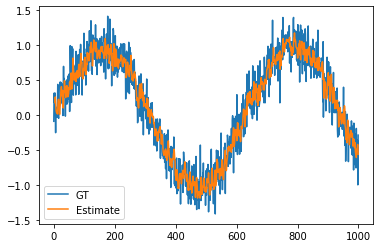

In [104]:
estimates = net(features)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimates.detach().numpy(), label='Estimate');
plt.legend();

### Why forecasting is not simple

In reality, for $t > 600$, we cannot use $x_{t}$ in AR. Instead we have to use $\hat{x}_{t}$ recursively:

$$
\begin{aligned}
\hat{x}_{601} &= f(x_{600}, x_{599}, x_{598}, x_{597}) \\  
\hat{x}_{602} &= f(\hat{x}_{601}, x_{600}, x_{599}, x_{598}) \\
\hat{x}_{603} &= f(\hat{x}_{602}, \hat{x}_{601}, x_{600}, x_{599}) \\
\hat{x}_{604} &= f(\hat{x}_{603}, \hat{x}_{602}, \hat{x}_{601}, x_{600})
\end{aligned}
$$

We create another array $predictions$, which has the first 596 elements from the $estimates$. Then, using these estimated values we forecast the next time stamp, and so on. This is different from what we did before, because previously we used all of the known data to do prediction. But now we predict later values based on other predicted values.

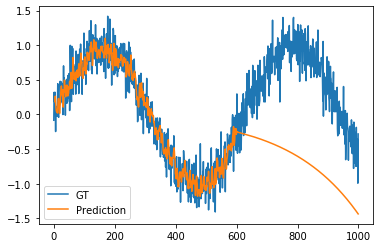

In [105]:
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    predictions[i] = net(
        predictions[(i - tau):i].reshape(1, -1)
    ).reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();

You can clearly see that the behavior of our predictive model is a lot different. I assume that for the 601-th value it predicted that it will be lower than the previous one, and then this decrease accumulated for the later values, resulting in a declining slope.

Now we look up

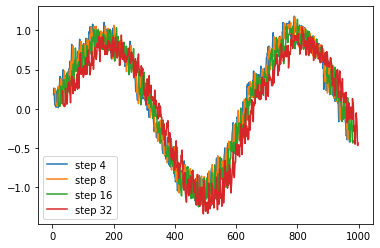

In [106]:
k = 33  # Look up to k - tau steps ahead

features = torch.zeros((T-k, k))
for i in range(tau):
    features[:, i] = X[i:T-k+i]

for i in range(tau, k):
    features[:, i] = net(features[:,(i-tau):i]).reshape((-1))

for i in (4, 8, 16, 32):
    plt.plot(time[i:T-k+i].numpy(), features[:, i].detach().numpy(),
             label=('step ' + str(i)))
plt.legend();

## Recurrent Neural Networks

We use the following setting

$$
p(x_{t}|x_{t-1},\ldots, x_{1}) \approx p(x_{t}|x_{t-1}, h_{t})
$$

Here $h_{t}$ is a latent variable that stores the sequence information:

$$
h_{t} = f(x_{t}, h_{t-1})
$$

### RNN

In [217]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [218]:
# RNN hyperparameters
input_dim = 4
hidden_dim = 100
num_layers = 2
output_dim = 1

lr = 0.001
epochs = 200

data_iter = DataLoader(train_data, 1, shuffle=True)
model = RNN(input_dim, hidden_dim, output_dim, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [219]:
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0.0
    hidden = model.initHidden(1)
    
    for x, y in data_iter:
        outputs, hidden = model(x, hidden)
        loss = criterion(outputs.view(-1), y.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 285.51486
loss: 46.95255
loss: 47.80772
loss: 30.87182
loss: 31.57994
loss: 30.92152
loss: 30.02501
loss: 29.87623
loss: 29.72468
loss: 29.76484
loss: 29.53461
loss: 29.63237
loss: 30.06398
loss: 29.57861
loss: 29.61892
loss: 29.67293
loss: 29.77193
loss: 29.53885
loss: 30.13765
loss: 29.50858


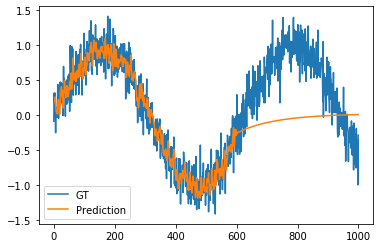

In [220]:
hidden = model.initHidden(1)
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    output, hidden = model(predictions[(i - tau):i].reshape(1, 1, -1), hidden)
    predictions[i] = output.reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();

### GRU

In [222]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [223]:
# GRU hyperparameters
input_dim = 4
hidden_dim = 100
num_layers = 2
output_dim = 1

lr = 0.001
epochs = 200

data_iter = DataLoader(train_data, 1, shuffle=True)
model = GRU(input_dim, hidden_dim, output_dim, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [224]:
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0.0
    hidden = model.initHidden(1)
    
    for x, y in data_iter:
        outputs, hidden = model(x, hidden)
        loss = criterion(outputs.view(-1), y.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 324.73276
loss: 223.78824
loss: 50.45956
loss: 45.67289
loss: 31.64506
loss: 29.92952
loss: 30.40643
loss: 29.67512
loss: 30.08149
loss: 29.51424
loss: 30.00974
loss: 29.68942
loss: 29.92653
loss: 29.81007
loss: 29.87384
loss: 29.87958
loss: 29.76950
loss: 29.87790
loss: 29.80153
loss: 29.65828


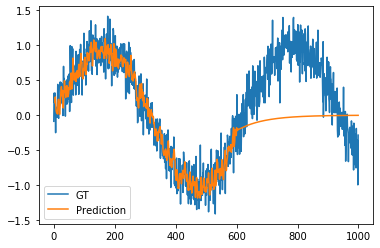

In [225]:
hidden = model.initHidden(1)
predictions = torch.zeros_like(estimates)
predictions[:(train_number - tau)] = estimates[:(train_number - tau)]

for i in range((train_number - tau), (T - tau)):
    output, hidden = model(predictions[(i - tau):i].reshape(1, 1, -1), hidden)
    predictions[i] = output.reshape(1)

plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), predictions.detach().numpy(), label='Prediction');
plt.legend();